# DS2 Assignment 1 - Nicolas Fernandez
## Predicting Property Prices from the Xindian District of New Taipei City, Taiwan
The task is to predict property prices using data taken from [UC Irvine](https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set) in order to build a web app where buyers/sellers could rate their homes.

The precise dataset being used is a cleaned version uploaded within Janos Divenyi's [github repository](https://github.com/divenyijanos/ceu-ml/tree/2023/data/real_estate).

The task asks to create a 20% subsample from the data and then create a 70/30% split from that subsample for a training and test sets.

## Reading Data and Creating Training and Test Splits

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np

# Reading the data from github
real_estate_data = pd.read_csv("https://raw.githubusercontent.com/divenyijanos/ceu-ml/2023/data/real_estate/real_estate.csv")

# Reading from file
#real_estate_data = pd.read_csv('real_estate.csv')

display(real_estate_data.head())
print(real_estate_data.info())

,id,transaction_date,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,latitude,longitude,house_price_of_unit_area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   414 non-null    int64  
 1   transaction_date                     414 non-null    float64
 2   house_age                            414 non-null    float64
 3   distance_to_the_nearest_MRT_station  414 non-null    float64
 4   number_of_convenience_stores         414 non-null    int64  
 5   latitude                             414 non-null    float64
 6   longitude                            414 non-null    float64
 7   house_price_of_unit_area             414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB
None


From the data there's a superfluous `id` column that will be dropped. The `transaction_date` column contains information about the year and month of the observation however it is in a non-standard format (`pd.to_datetime()` cannot be used) and will not be included for base feature models. The `latitude` and `longitude` columns contains geographical data for each column but that cannot be made sense of without feature engineering.

In [2]:
# Importing required library
from sklearn.model_selection import train_test_split

# Dropping the id column because it's unecessary
real_estate_data.drop(columns=['id'], inplace=True)

# Setting the pseudo random seed for the due date of the assignment
prng = np.random.RandomState(20240322)

# Creating a randomly selected 20% sample of the data, creating target variable 'outcome'
real_estate_sample = real_estate_data.sample(frac=0.2, random_state=prng)
outcome = real_estate_sample["house_price_of_unit_area"]
all_features_sample = real_estate_sample.drop(columns=['house_price_of_unit_area'])

# Selecting the numeric, non-feature engineered columns as base features for model evaluation as a list
base_features = ['house_age', 'distance_to_the_nearest_MRT_station', 'number_of_convenience_stores']

# Creating training and testing splits from the sample, using a 30% split per specifications
X_train, X_test, y_train, y_test = train_test_split(all_features_sample, outcome, test_size=0.3, random_state=prng)

print(f"Size of the training set: {X_train.shape}, size of the test set: {X_test.shape}")
X_train.head()

Size of the training set: (58, 6), size of the test set: (25, 6)


,transaction_date,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,latitude,longitude
331,2013.333,25.6,4519.69000,0,24.94826,121.49587
386,2012.833,0.0,185.42960,0,24.97110,121.53170
267,2012.833,34.7,482.75810,5,24.97433,121.53863
252,2012.833,5.9,90.45606,9,24.97433,121.54310
197,2013.250,34.4,126.72860,8,24.96881,121.54089


## Evalaution Function

In [3]:
# Defining the loss function, using Root Mean Squared Log Error
def calculateRMSLE(prediction, y_obs):
    return round(np.sqrt(np.mean((np.log(np.where(prediction < 0, 0, prediction) + 1) - np.log(y_obs + 1))**2)), 4)

RMSLE is an appropriate loss function since its a calculation that is less sensitive to outliers by design, appropriate for property price prediction. The risk (from a business perspective) from making a wrong prediction could be either under or over pricing homes in certain areas because RMSLE may treat values as outliers that may have be more important than they seem. Overall, however, property prices are susceptible to large increases based on several factors and can increase in price in orders of magnitude rather than a more gradual scale and for this reason using a loss function on a logarithmic scale is preferred.

## Rigid Models
Initially OLS models without any non-linearity will be created

### Benchmark Model

In [4]:
# Creating a simple benchmark model for comparison, mean value of target variable for training set
benchmark = np.mean(y_train)

# Calculating performance of benchmark on test set using loss function
benchmark_pred = ['Benchmark', calculateRMSLE(benchmark, y_train), calculateRMSLE(benchmark, y_test)]

# Storing and displaying results in a dataframe
results = pd.DataFrame([benchmark_pred], columns=['Model', 'Train', 'Test'])
results

,Model,Train,Test
0,Benchmark,0.3434,0.3221


### OLS Single Feature - `distance_to_the_nearest_MRT_station`

In [5]:
# Importing required library
from sklearn.linear_model import LinearRegression

# Creating OLS model trained on only `distance_to_the_nearest_MRT_station`
ols_single = LinearRegression().fit(X_train[['distance_to_the_nearest_MRT_station']], y_train)

# Creating predictions for model and calculating RMSLE
train_error = calculateRMSLE(ols_single.predict(X_train[['distance_to_the_nearest_MRT_station']]), y_train)
test_error = calculateRMSLE(ols_single.predict(X_test[['distance_to_the_nearest_MRT_station']]), y_test)
ols_single_pred = ['Single Feature OLS', train_error, test_error]

# Adding to results
results.loc[len(results)] = ols_single_pred
results

,Model,Train,Test
0,Benchmark,0.3434,0.3221
1,Single Feature OLS,0.2250,0.2305


This model improves upon using the average of the target variable as a predictive model for our target as the RMSLE's improves using a single feature from the dataset. The model can be significantly improved as it likely does not catch much of the complexity of the data but using `distance_to_the_nearest_MRT_station`, determined to be the most signficant variable to predicting property prices, as an explanatory variable has improved our predictions.

### Multivariate OLS
Building an OLS model that uses all the available meaningful base features instead of a single variable.

In [6]:
# Creating multivariate OLS model and fitting to training data
ols_multi = LinearRegression().fit(X_train[base_features], y_train)

# Creating predictions
train_error = calculateRMSLE(ols_multi.predict(X_train[base_features]), y_train)
test_error = calculateRMSLE(ols_multi.predict(X_test[base_features]), y_test)
ols_multi_pred = ['Base Multi OLS', train_error, test_error]

# Adding to results
results.loc[len(results)] = ols_multi_pred
results

,Model,Train,Test
0,Benchmark,0.3434,0.3221
1,Single Feature OLS,0.2250,0.2305
2,Base Multi OLS,0.1993,0.2317


The multivariate model using all the available base features improved the predictive power on the training set but performed slightly worse on the test set. Using all the available features does not increase the predictive power over using only a single feature. This implies that the other features in the data (`house_age` and `number_of_convenience_stores`) causes a slight overfit compared to only using `distance_to_the_nearest_MRT_station` and that we may have introduced more noise, bias, and/or variance into our model.

## Flexible Models
Below more flexible models will be created

### Polynomial OLS with Interactions

In [7]:
# Importing required library
from sklearn.preprocessing import PolynomialFeatures

# Creating Polynomial object to create polynomial terms and interactions in training data
poly_interactions = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_poly = poly_interactions.fit_transform(X_train[base_features])

# Creating polynomial OLS model
ols_poly = LinearRegression().fit(X_poly, y_train)

# Creating predictions
train_error = calculateRMSLE(ols_poly.predict(X_poly), y_train)
test_error = calculateRMSLE(ols_poly.predict(poly_interactions.transform(X_test[base_features])), y_test)
ols_poly_pred = ['Base Poly OLS', train_error, test_error]

# Adding to results
results.loc[len(results)] = ols_poly_pred
results

,Model,Train,Test
0,Benchmark,0.3434,0.3221
1,Single Feature OLS,0.2250,0.2305
2,Base Multi OLS,0.1993,0.2317
3,Base Poly OLS,0.1742,0.1611


Adding polynomial and interaction terms using base features only to the model has improved the RMSLE on the test set somewhat significantly. It appears that adding these terms to the OLS model and making it more flexible has captured non-linearity in the data. Also the interaction terms may be reducing bias in the model which would also increase the performance on the test set.

### Feature Engineering
Feature Engineering will be done on the splits of the sample to ensure that they remain intact and the same amongst all the models.

From research, New Taipei City is actually within Taipei City. For the purposes of this analysis the city center for Taipei City (not New Taipei) will be considered the city center for which all observations will be compared to. The geographical data will then be converted to km distance from the city center based on the provided coordinates and added to the dataframe as a new column. The latitude for the city center that will be used is 25.03583333 and the longitude is 121.5683333. The information was pulled from [here](https://gist.github.com/nkrusch/848e4d6ca0be879e2e03b78b051f17da) and verified with Google Maps.

The transaction dates within the data follow the format 2013.500, for example, with the number to the left of the decimal being the year and the number to the right of the decimal being the decimal representation of the month (.500 = June = <sup>6</sup>/<sub>12</sub>). The only quirk to this is that .000 = December. This data will be converted and split into two columns, one for the year and another for the month.

These features are likely to be important because from general domain knowledge property prices tend to increase the closer they are to the geographical city center of the respective major city and also property prices from year to year tend to increase as well, sometimes due more to general trends in the market and also sometimes due to general inflation. Enabling this data to be used will likely prove beneficial for model building.

In [8]:
# Defining function for creating year and month columns from transaction_date as categorical columns
def date_fix(df):
    df['year'] = df['transaction_date'].astype(int)
    df['year'] = df['year'].astype('category')
    
    df['month'] = np.where(df['transaction_date'] % 1 == 0, 12, 
                           round((df['transaction_date'] % 1) * 12).astype(int))
    df['month'] = df['month'].astype('category')

# Defining function for calculating distance from city center in km
def cc_distance(lat, lon):
    # City center coordinates (Taipei)
    cc_lat = 25.03583333
    cc_lon = 121.5683333
    
    # Convert latitude and longitude from degrees to radians
    lat, lon, cc_lat, cc_lon = np.radians([lat, lon, cc_lat, cc_lon])

    # Calculating difference from city center
    diff_lon = lon - cc_lon
    diff_lat = lat - cc_lat

    # Using the Haversine Formula to calculate distance from radians
    a = np.sin(diff_lat / 2) ** 2 + np.cos(lat) * np.cos(cc_lat) * np.sin(diff_lon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    km_distance = 6371 * c  # 6371 = Radius of Earth in km

    return km_distance

# Creating copies of X_train and X_test
X_train_fe = X_train.copy()
X_test_fe = X_test.copy()

# Running above functions on data for feature engineering
date_fix(X_train_fe)
X_train_fe['km_distance_from_cc'] = X_train_fe.apply(lambda row: cc_distance(row['latitude'], row['longitude']), axis=1)

date_fix(X_test_fe)
X_test_fe['km_distance_from_cc'] = X_test_fe.apply(lambda row: cc_distance(row['latitude'], row['longitude']), axis=1)

# Dropping `transaction_date`, `latitude`, and `longitude` columns from the feature engineered splits as they are no longer necessary
X_train_fe.drop(columns=['transaction_date', 'latitude', 'longitude'], inplace=True)
X_test_fe.drop(columns=['transaction_date', 'latitude', 'longitude'], inplace=True)

### OLS Model with Feature Engineered Data

In [9]:
# Importing required libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Setting up OneHotEncoder for handling categorical variables 'year' and 'month'
one_hot_encoder = OneHotEncoder(sparse_output=False, drop="first")
categorical_vars = ['year', 'month']

# Using ColumnTransformer to create the dummies based on defined OneHotEncoder
column_transformer = ColumnTransformer([("create_dummies", one_hot_encoder, categorical_vars)], 
                                       remainder="passthrough")

# Creating OLS model for FE data with Pipeline
pipe_ols_fe = Pipeline([("preprocess", column_transformer),
                   ("ols", LinearRegression())])

# Fitting the data
pipe_ols_fe.fit(X_train_fe, y_train)

# Creating predictions
train_error = calculateRMSLE(pipe_ols_fe.predict(X_train_fe), y_train)
test_error = calculateRMSLE(pipe_ols_fe.predict(X_test_fe), y_test)
ols_fe_pred = ['FE OLS', train_error, test_error]

# Adding to results
results.loc[len(results)] = ols_fe_pred
results

,Model,Train,Test
0,Benchmark,0.3434,0.3221
1,Single Feature OLS,0.2250,0.2305
2,Base Multi OLS,0.1993,0.2317
3,Base Poly OLS,0.1742,0.1611
4,FE OLS,0.1625,0.2512


The OLS model with feature engineering performed worse on the test set than the non-feature engieered models. This model is not accounting for any non-linearity in the data and also not adding interaction terms, but in general it appears that the feature engineered variables are causing an overfit on the test set given the higher RMSLE scores.

### Polynomial OLS with Feature Engineered Data

In [10]:
# Importing required library
from sklearn.feature_selection import VarianceThreshold # To account for categorical values with zero variance

# Initiating VarianceThreshold to drop categorial variables with no variance
drop_no_variance = VarianceThreshold()

# Creating model with Pipeline
pipe_ols_poly_fe = Pipeline([
    ('preprocess', column_transformer),
    ('interactions', poly_interactions),
    ('drop_zero_variance', drop_no_variance),
    ('ols', LinearRegression())
])

# Fitting the data
pipe_ols_poly_fe.fit(X_train_fe, y_train)

# Creating predictions
train_error = calculateRMSLE(pipe_ols_poly_fe.predict(X_train_fe), y_train)
test_error = calculateRMSLE(pipe_ols_poly_fe.predict(X_test_fe), y_test)
ols_poly_fe_pred = ['FE Poly OLS', train_error, test_error]

# Adding to results
results.loc[len(results)] = ols_poly_fe_pred
results

,Model,Train,Test
0,Benchmark,0.3434,0.3221
1,Single Feature OLS,0.2250,0.2305
2,Base Multi OLS,0.1993,0.2317
3,Base Poly OLS,0.1742,0.1611
4,FE OLS,0.1625,0.2512
5,FE Poly OLS,0.0363,1.1234


There is a clear overfit when adding interactions and polynomial terms on the feature engineered data to account for non-linearity, much moreso than without with  additional terms. This implies that while there is some non-linearity in the data, it clearly relates to the features from the base features rather than the feature engineered data.

### LASSO

In [11]:
# Importing required library
from sklearn.linear_model import LassoCV

# Setting LASSO to a pipeline
pipe_lasso = Pipeline([
    ('preprocess', column_transformer),
    ('interactions', poly_interactions),
    ('drop_zero_variance', drop_no_variance),
    ('lasso', LassoCV())
])

# Fitting the model to the data
pipe_lasso.fit(X_train_fe, y_train)

# Creating predictions
train_error = calculateRMSLE(pipe_lasso.predict(X_train_fe), y_train)
test_error = calculateRMSLE(pipe_lasso.predict(X_test_fe), y_test)
lasso_pred = ['FE LASSO', train_error, test_error]

# Adding to results
results.loc[len(results)] = lasso_pred
results

,Model,Train,Test
0,Benchmark,0.3434,0.3221
1,Single Feature OLS,0.2250,0.2305
2,Base Multi OLS,0.1993,0.2317
3,Base Poly OLS,0.1742,0.1611
4,FE OLS,0.1625,0.2512
5,FE Poly OLS,0.0363,1.1234
6,FE LASSO,0.1718,0.1873


The lambda tuning parameter of the LASSO sorted through the coefficients and effectively removed the predictors that it deemed to be unnecessary by reducing their coefficients to (effectively) 0. As a result, as already mentioned, the RMSLE value on the test set is improved comparatively. It's worth noting however that it still does not outperform the Base Poly OLS model and it's still likely that the feature engineered data is causing an overfit in some capacity when not handled correctly.

### Random Forest

In [12]:
# Importing required library
from sklearn.ensemble import RandomForestRegressor

# Creating a Random Forest model with Pipeline
pipe_rf = Pipeline([('preprocess', column_transformer),
    ("rf", RandomForestRegressor(random_state=prng))])

# Fitting the model to the feature engineered data
pipe_rf.fit(X_train_fe, y_train)

# Creating predictions
train_error = calculateRMSLE(pipe_rf.predict(X_train_fe), y_train)
test_error = calculateRMSLE(pipe_rf.predict(X_test_fe), y_test)
rf_pred = ['RF', train_error, test_error]

# Adding to results
results.loc[len(results)] = rf_pred
results

,Model,Train,Test
0,Benchmark,0.3434,0.3221
1,Single Feature OLS,0.2250,0.2305
2,Base Multi OLS,0.1993,0.2317
3,Base Poly OLS,0.1742,0.1611
4,FE OLS,0.1625,0.2512
5,FE Poly OLS,0.0363,1.1234
6,FE LASSO,0.1718,0.1873
7,RF,0.0760,0.1882


The Random Forest model performs better likely because using bagging and regularization allows it to be more robust to noise within the data since it averages predictions among many trees, in this case 100 (the default value). The RF however is not predicting as well as the Base Poly OLS or FE LASSO models which implies that the RF is not capturing some of the non-linearity that the the other two seem to be capturing and also some of the feature engineered variables add additional complexity.

Below a table is shown with the feature importance of the Random Forest model created from the feature engineered data.

In [13]:
# Creating dataframe for readability for displaying variable importance
rf_var_imp = pd.DataFrame(
    pipe_rf['rf'].feature_importances_, 
    pipe_rf[:-1].get_feature_names_out())\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

# Creating cumulative sum column
rf_var_imp['cumulative_imp'] = rf_var_imp['imp'].cumsum()

# Displaying dataframe with formatting
rf_var_imp.style.format({'imp': lambda x: f'{x:,.1%}', 'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,remainder__distance_to_the_nearest_MRT_station,72.3%,72.3%
1,remainder__km_distance_from_cc,10.5%,82.8%
2,remainder__house_age,8.2%,91.1%
3,remainder__number_of_convenience_stores,3.9%,95.0%
4,create_dummies__year_2013,0.9%,95.9%
5,create_dummies__month_10,0.7%,96.6%
6,create_dummies__month_4,0.6%,97.2%
7,create_dummies__month_8,0.5%,97.8%
8,create_dummies__month_3,0.5%,98.3%
9,create_dummies__month_5,0.4%,98.7%


From these results we can see that `distance_to_the_nearest_MRT_station` is in fact the most important feature in the data, as theorized earlier. The next three significant features (although significantly less so than MRT station distance) are `km_distance_from_cc`, `house_age`, and `number_of_convenience_stores`. This makes sense as people in general value properties more that are closer to the city center and the older the house usually the less expensive it tends to be. It also appears that a house being closer to more convenience stores also influences the price of properties in Taipei which implies that people in that cit value having better access to convenience stores.

Conversely, the date of the purchase appears to have little to do with making a good prediction. This could be that since there isn't much variance in the amount of time within the data that the transaction date has little variance.

Below we take a look at a single tree to illustrate:

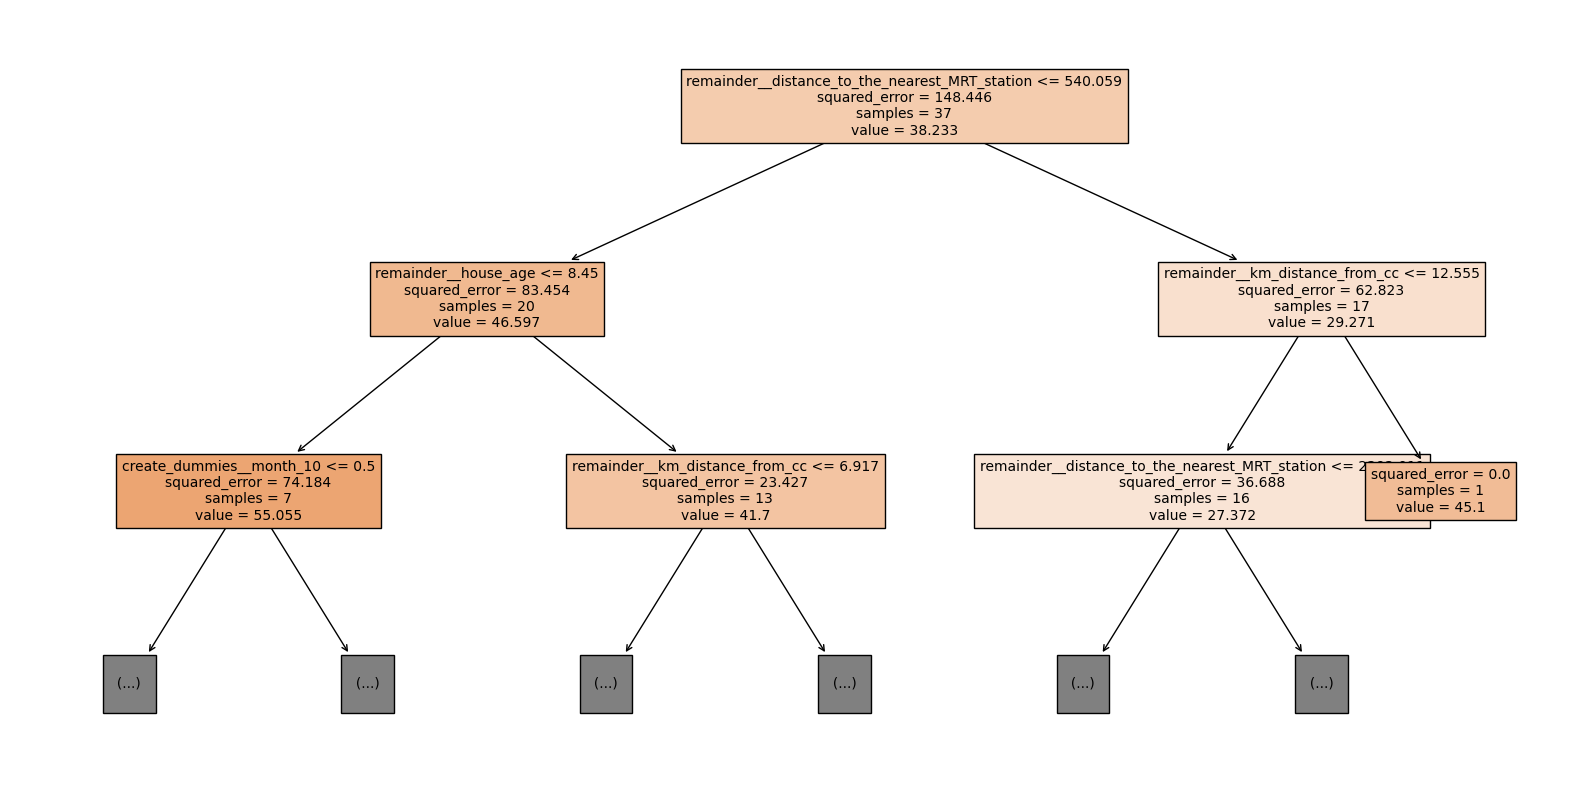

In [14]:
# Importing required libraries
from sklearn import tree
import matplotlib.pyplot as plt

# Look at single trees
chosen_tree = pipe_rf["rf"].estimators_[0]

plt.figure(figsize=(20,10))

# Plot tree with adjusted settings
tree.plot_tree(chosen_tree, 
               feature_names=pipe_rf[:-1].get_feature_names_out(), 
               max_depth=2, # Plotting only a depth of 2 splits
               fontsize=10,  # Adjust font size of text in nodes
               filled=True)  # Fill nodes with colors

plt.show()

### XGBoost Model

In [15]:
# Importing required library
import xgboost as xgb

# Creating XGB model, fitting to feature engineered training data
xgb_fe = xgb.XGBRegressor(enable_categorical=True).fit(X_train_fe, y_train)

# Creating predictions
train_error = calculateRMSLE(xgb_fe.predict(X_train_fe), y_train)
test_error = calculateRMSLE(xgb_fe.predict(X_test_fe), y_test)
xgb_pred = ['XGB', train_error, test_error]

# Adding to results
results.loc[len(results)] = xgb_pred
results

,Model,Train,Test
0,Benchmark,0.3434,0.3221
1,Single Feature OLS,0.2250,0.2305
2,Base Multi OLS,0.1993,0.2317
3,Base Poly OLS,0.1742,0.1611
4,FE OLS,0.1625,0.2512
5,FE Poly OLS,0.0363,1.1234
6,FE LASSO,0.1718,0.1873
7,RF,0.0760,0.1882
8,XGB,0.0000,0.1921


In [16]:
# Viewing features from XGBoost model to see how it split the data, which categories it used, etc.
xgb_fe.get_booster().trees_to_dataframe().head()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,distance_to_the_nearest_MRT_station,665.063599,0-1,0-2,0-2,4822.441410,58.0,None
1,0,1,0-1,house_age,7.100000,0-3,0-4,0-4,838.944946,37.0,None
2,0,2,0-2,km_distance_from_cc,12.772239,0-5,0-6,0-6,303.041748,21.0,None
3,0,3,0-3,month,NaN,0-8,0-7,0-7,180.757812,12.0,"[0, 1, 2, 3, 5, 8, 11]"
4,0,4,0-4,distance_to_the_nearest_MRT_station,329.974701,0-9,0-10,0-10,366.385590,25.0,None


The XGBoost model is capturing some but not all of the non-linearity in the data and is therefore performing worse than the two models mentioned on the test set. It could also be that some of the features used may be adding more noise/bias/variance to the data rather than helping and XGBoost may not be doing as good of a job of accounting for this as the Random Forest model.

## Initial Analysis
From the models constructed so far, it would appear that the Base Poly OLS model is our best choice for going forward and creating a web app designed to aid buyers/sellers to rate their homes. As it stands, however, I would like to test adding more data to the training set to see how the models fare and if they improve or worsen. Some more options for potential improvement are cross-validation, hyperparameter tuning (e.g. adding a grid search to the RF), or using another model type altogether.

## Rerunning Models on Full Dataset, Excluding Test Sets
Below several of the models created (both rigid and flexible) will be tested on the overall dataset. We will be careful to give the models trained on the full dataset the same comparison base and not include that test data in the training set.

In [17]:
# Creating the training set for the full data excluding the test set
real_estate_full = real_estate_data.loc[~real_estate_data.index.isin(X_test.index)]
y_train_full = real_estate_full['house_price_of_unit_area']
X_train_full = real_estate_full.drop(columns=["house_price_of_unit_area"])

# Running feature engineering on full sample
X_train_full_fe = X_train_full.copy()
date_fix(X_train_full_fe)
X_train_full_fe['km_distance_from_cc'] = X_train_full_fe.apply(lambda row: cc_distance(row['latitude'], row['longitude']), axis=1)
X_train_full_fe.drop(columns=['transaction_date', 'latitude', 'longitude'], inplace=True)

# Checking sample size results
print(f'Size of original dataset: {real_estate_data.shape[0]}')
print(f'Shape of full base training set: {X_train_full.shape}, shape of base test set: {X_test.shape}')
print(f'Shape of feature engineered full training set: {X_train_full_fe.shape}, shape of feature engineered test set: {X_test_fe.shape}')

Size of original dataset: 414
Shape of full base training set: (389, 6), shape of base test set: (25, 6)
Shape of feature engineered full training set: (389, 6), shape of feature engineered test set: (25, 6)


In [18]:
# Running the single OLS on the full training set
ols_single_full = LinearRegression().fit(X_train_full[['distance_to_the_nearest_MRT_station']], y_train_full)

# Creating predictions for model and calculating RMSLE
train_error = calculateRMSLE(ols_single_full.predict(X_train_full[['distance_to_the_nearest_MRT_station']]), y_train_full)
test_error = calculateRMSLE(ols_single_full.predict(X_test[['distance_to_the_nearest_MRT_station']]), y_test)
ols_single_pred_full = ['Single Feature OLS Full', train_error, test_error]

# Adding to results
results.loc[len(results)] = ols_single_pred_full

# Running the base features Polynomial OLS on the full training set
X_poly_full = poly_interactions.fit_transform(X_train_full[base_features])

# Creating polynomial OLS model
ols_poly_full = LinearRegression().fit(X_poly_full, y_train_full)

# Creating predictions
train_error = calculateRMSLE(ols_poly_full.predict(X_poly_full), y_train_full)
test_error = calculateRMSLE(ols_poly_full.predict(poly_interactions.transform(X_test[base_features])), y_test)
ols_poly_pred_full = ['Base Poly OLS Full', train_error, test_error]

# Adding to results
results.loc[len(results)] = ols_poly_pred_full

# Running the Random Forest model on the full training set
pipe_rf_full = Pipeline([('preprocess', column_transformer),
    ("rf", RandomForestRegressor(random_state=prng))])

# Fitting the model to the feature engineered data
pipe_rf_full.fit(X_train_full_fe, y_train_full)

# Creating predictions
train_error = calculateRMSLE(pipe_rf_full.predict(X_train_full_fe), y_train_full)
test_error = calculateRMSLE(pipe_rf_full.predict(X_test_fe), y_test)
rf_pred_full = ['RF Full', train_error, test_error]

# Adding to results
results.loc[len(results)] = rf_pred_full
results

,Model,Train,Test
0,Benchmark,0.3434,0.3221
1,Single Feature OLS,0.2250,0.2305
2,Base Multi OLS,0.1993,0.2317
3,Base Poly OLS,0.1742,0.1611
4,FE OLS,0.1625,0.2512
5,FE Poly OLS,0.0363,1.1234
6,FE LASSO,0.1718,0.1873
7,RF,0.0760,0.1882
8,XGB,0.0000,0.1921
9,Single Feature OLS Full,0.3477,0.2211


The models chosen to be trained on the full set were the least flexible single feature OLS, the flexible polynomial OLS using base features, and the Random Forest. From the results we can see that the single feature OLS and RF models improved on the test set but the Base Poly OLS model performed worse when trained on the full training set, though only slightly. Both of these models still perform better than the single feature OLS and between them the RF model improved significantly. This can be attributed to adding more data that allowed the RF model to better generalize the trends in the data through regularization and bagging to produce a better prediction on the test set.

## Rerunning Base Poly OLS and RF Models on New Seed
For the final step to test the results of the best two models from the analysis they will be rerun to the same specifications by using a new random seed to see how the results differ.

In [19]:
# Initializing a new seed using March 23 date
new_seed = np.random.RandomState(20240323)

# Creating same sample on new seed
real_estate_sample = real_estate_data.sample(frac=0.2, random_state=new_seed)
outcome = real_estate_sample["house_price_of_unit_area"]
all_features_sample = real_estate_sample.drop(columns=['house_price_of_unit_area'])

# Creating training and testing splits from the sample, using a 30% split per specifications
X_train, X_test, y_train, y_test = train_test_split(all_features_sample, outcome, test_size=0.3, random_state=new_seed)

# Retraining the Base Poly OLS model and creating predictions
X_poly = poly_interactions.fit_transform(X_train[base_features])
ols_poly = LinearRegression().fit(X_poly, y_train)

train_error = calculateRMSLE(ols_poly.predict(X_poly), y_train)
test_error = calculateRMSLE(ols_poly.predict(poly_interactions.transform(X_test[base_features])), y_test)

ols_poly_new_pred = ['Base Poly OLS New Seed', train_error, test_error]
results.loc[len(results)] = ols_poly_new_pred

# Recreating feature engineering on resplit data off of new seed
X_train_fe = X_train.copy()
X_test_fe = X_test.copy()

date_fix(X_train_fe)
X_train_fe['km_distance_from_cc'] = X_train_fe.apply(lambda row: cc_distance(row['latitude'], row['longitude']), axis=1)

date_fix(X_test_fe)
X_test_fe['km_distance_from_cc'] = X_test_fe.apply(lambda row: cc_distance(row['latitude'], row['longitude']), axis=1)

X_train_fe.drop(columns=['transaction_date', 'latitude', 'longitude'], inplace=True)
X_test_fe.drop(columns=['transaction_date', 'latitude', 'longitude'], inplace=True)

# Retraining the RF model and creating predictions with the new seed
pipe_rf = Pipeline([('preprocess', column_transformer),
    ("rf", RandomForestRegressor(random_state=new_seed))])
pipe_rf.fit(X_train_fe, y_train)

train_error = calculateRMSLE(pipe_rf.predict(X_train_fe), y_train)
test_error = calculateRMSLE(pipe_rf.predict(X_test_fe), y_test)

rf_pred_new = ['RF New Seed', train_error, test_error]
results.loc[len(results)] = rf_pred_new

# Getting full training set on new seed
real_estate_full = real_estate_data.loc[~real_estate_data.index.isin(X_test.index)]
y_train_full = real_estate_full['house_price_of_unit_area']
X_train_full = real_estate_full.drop(columns=["house_price_of_unit_area"])

# Running feature engineering on full sample
X_train_full_fe = X_train_full.copy()
date_fix(X_train_full_fe)
X_train_full_fe['km_distance_from_cc'] = X_train_full_fe.apply(lambda row: cc_distance(row['latitude'], row['longitude']), axis=1)
X_train_full_fe.drop(columns=['transaction_date', 'latitude', 'longitude'], inplace=True)

# Running the base features Polynomial OLS on new full training set
X_poly_full = poly_interactions.fit_transform(X_train_full[base_features])
ols_poly_full = LinearRegression().fit(X_poly_full, y_train_full)

train_error = calculateRMSLE(ols_poly_full.predict(X_poly_full), y_train_full)
test_error = calculateRMSLE(ols_poly_full.predict(poly_interactions.transform(X_test[base_features])), y_test)

ols_poly_pred_full = ['Base Poly OLS Full New Seed', train_error, test_error]
results.loc[len(results)] = ols_poly_pred_full

# Running the Random Forest model on the new full training set
pipe_rf_full = Pipeline([('preprocess', column_transformer),
    ("rf", RandomForestRegressor(random_state=new_seed))])
pipe_rf_full.fit(X_train_full_fe, y_train_full)

train_error = calculateRMSLE(pipe_rf_full.predict(X_train_full_fe), y_train_full)
test_error = calculateRMSLE(pipe_rf_full.predict(X_test_fe), y_test)

rf_pred_full = ['RF Full New Seed', train_error, test_error]
results.loc[len(results)] = rf_pred_full

results

,Model,Train,Test
0,Benchmark,0.3434,0.3221
1,Single Feature OLS,0.2250,0.2305
2,Base Multi OLS,0.1993,0.2317
3,Base Poly OLS,0.1742,0.1611
4,FE OLS,0.1625,0.2512
5,FE Poly OLS,0.0363,1.1234
6,FE LASSO,0.1718,0.1873
7,RF,0.0760,0.1882
8,XGB,0.0000,0.1921
9,Single Feature OLS Full,0.3477,0.2211


After testing the best two models on a new seed we can see that they performed even better on a new seed, with the RF model still performing the best overall. This helps to confirm that the model performances are not a fluke on a single seed but are consistent enough to go forward with.

## Final Analysis

More data tends to improve and regularize any potentially extraneous data points in smaller sample sizes it would appear that this held true in this case as well. Having seen how the RF model performed significantly better it gives me more confidence that I should launch the web app using the RF model as theoretically with even more data to train the model on the predictive power should further increase (though the gains of said increase may reduce). Additionally, further tweaking of RF model could yield even better results.